# 投资者情绪专题

## 数据准备

In [1]:
import sys
import os
import cudf  #CUDA计算
import pandas as pd

# 自行编写的包
sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')

# Stata
from pystata import config  # noqa

config.init('mp')
# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata
               Love U

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


In [2]:
df = (
        cudf.read_parquet(
                DATASETS_PATH + 'FORUM_SENT_TRANS.parquet',
                columns=['PostDate', 'Stockcode', 'PostSource', 'PositiveSentIndexA', 'PositiveSentIndexB', 'TotalPosts', 'AvgReadings',
                         'AvgComments', 'AvgPositThumbUps'])
        .query("PostDate>=20140101 ")

)

In [3]:
df.set_index(['PostDate', 'Stockcode']).sort_index().to_pandas()

PostSource  PositiveSentIndexA  PositiveSentIndexB  \
PostDate Stockcode                                                       
20140101 000030.SZ           1                 NaN                 NaN   
         000030.SZ           1                 NaN                 NaN   
         000034.SZ           1                 NaN                 NaN   
         000034.SZ           1                 NaN                 NaN   
         000043.SZ           1                 NaN                 NaN   
...                        ...                 ...                 ...   
20211016 900948.SH           1                 NaN                 NaN   
         900952.SH           1                 NaN                 NaN   
         900953.SH           1                 NaN                 NaN   
         900955.SH           1                 NaN                 NaN   
         900957.SH           1                 NaN                 NaN   

                    TotalPosts  AvgReadings  AvgComments  AvgPositThumbUps  
PostDate Stockcode                                                          
20140101 000030.SZ           0          NaN          NaN               NaN  
         000030.SZ           0          NaN          NaN               NaN  
         000034.SZ           0          NaN          NaN               NaN  
         000034.SZ           0          NaN          NaN               NaN  
         000043.SZ           0          NaN          NaN               NaN  
...                        ...          ...          ...               ...  
20211016 900948.SH           0          NaN          NaN               NaN  
         900952.SH           0          NaN          NaN               NaN  
         900953.SH           0          NaN          NaN               NaN  
         900955.SH           0          NaN          NaN               NaN  
         900957.SH           0          NaN          NaN               NaN  

[11846133 rows x 7 columns]

## 指标计算

计算加权影响力,参数为影响力系数,点赞评论阅读

In [4]:
# 每日总量
df['DayTotalPosts'] = df.groupby(['PostDate', ])['TotalPosts'].transform('sum')
df['DayAvgReadings'] = df.groupby(['PostDate', ])['AvgReadings'].transform('sum')
df['DayAvgComments'] = df.groupby(['PostDate', ])['AvgComments'].transform('sum')
df['DayAvgPositThumbUps'] = df.groupby(['PostDate', ])['AvgPositThumbUps'].transform('sum')

# 加权因子总量
df['DayTotalPostsFactor'] = df['TotalPosts'] / df['DayTotalPosts']
df['DayAvgReadingsFactor'] = df['AvgReadings'] / df['DayAvgReadings']
df['DayAvgCommentsFactor'] = df['AvgComments'] / df['DayAvgComments']
df['DayAvgPositThumbUpsFactor'] = df['AvgPositThumbUps'] / df['DayAvgPositThumbUps']

# 个股加权情绪因子
df['PositiveSentIndexAFactor'] = (
        (df['DayTotalPostsFactor'] * 0.3 + df['DayAvgReadingsFactor'] * 0.5 +
         df['DayAvgCommentsFactor'] * 0.1 + df['DayAvgPositThumbUpsFactor'] * 0.1)
        * df['PositiveSentIndexA']
)

df['PositiveSentIndexBFactor'] = (
        (df['DayTotalPostsFactor'] * 0.3 + df['DayAvgReadingsFactor'] * 0.5 +
         df['DayAvgCommentsFactor'] * 0.1 + df['DayAvgPositThumbUpsFactor'] * 0.1)
        * df['PositiveSentIndexB']
)

# 每日情绪因子
df['DayPositiveSentIndexA'] = df.groupby(['PostDate', 'Stockcode'])['PositiveSentIndexAFactor'].transform('sum')
df['DayPositiveSentIndexB'] = df.groupby(['PostDate', 'Stockcode'])['PositiveSentIndexBFactor'].transform('sum')

df.set_index(['PostDate', 'Stockcode']).sort_index()

PostSource PositiveSentIndexA PositiveSentIndexB  \
PostDate Stockcode                                                     
20140101 000030.SZ           1               <NA>               <NA>   
         000030.SZ           1               <NA>               <NA>   
         000034.SZ           1               <NA>               <NA>   
         000034.SZ           1               <NA>               <NA>   
         000043.SZ           1               <NA>               <NA>   
...                        ...                ...                ...   
20211016 900948.SH           1               <NA>               <NA>   
         900952.SH           1               <NA>               <NA>   
         900953.SH           1               <NA>               <NA>   
         900955.SH           1               <NA>               <NA>   
         900957.SH           1               <NA>               <NA>   

                    TotalPosts AvgReadings AvgComments AvgPositThumbUps  \
PostDate Stockcode                                                        
20140101 000030.SZ           0        <NA>        <NA>             <NA>   
         000030.SZ           0        <NA>        <NA>             <NA>   
         000034.SZ           0        <NA>        <NA>             <NA>   
         000034.SZ           0        <NA>        <NA>             <NA>   
         000043.SZ           0        <NA>        <NA>             <NA>   
...                        ...         ...         ...              ...   
20211016 900948.SH           0        <NA>        <NA>             <NA>   
         900952.SH           0        <NA>        <NA>             <NA>   
         900953.SH           0        <NA>        <NA>             <NA>   
         900955.SH           0        <NA>        <NA>             <NA>   
         900957.SH           0        <NA>        <NA>             <NA>   

                    DayTotalPosts DayAvgReadings DayAvgComments  \
PostDate Stockcode                                                
20140101 000030.SZ              0           <NA>           <NA>   
         000030.SZ              0           <NA>           <NA>   
         000034.SZ              0           <NA>           <NA>   
         000034.SZ              0           <NA>           <NA>   
         000043.SZ              0           <NA>           <NA>   
...                           ...            ...            ...   
20211016 900948.SH              0           <NA>           <NA>   
         900952.SH              0           <NA>           <NA>   
         900953.SH              0           <NA>           <NA>   
         900955.SH              0           <NA>           <NA>   
         900957.SH              0           <NA>           <NA>   

                   DayAvgPositThumbUps  DayTotalPostsFactor  \
PostDate Stockcode                                            
20140101 000030.SZ                <NA>                  NaN   
         000030.SZ                <NA>                  NaN   
         000034.SZ                <NA>                  NaN   
         000034.SZ                <NA>                  NaN   
         000043.SZ                <NA>                  NaN   
...                                ...                  ...   
20211016 900948.SH                <NA>                  NaN   
         900952.SH                <NA>                  NaN   
         900953.SH                <NA>                  NaN   
         900955.SH                <NA>                  NaN   
         900957.SH                <NA>                  NaN   

                   DayAvgReadingsFactor DayAvgCommentsFactor  \
PostDate Stockcode                                             
20140101 000030.SZ                 <NA>                 <NA>   
         000030.SZ                 <NA>                 <NA>   
         000034.SZ                 <NA>                 <NA>   
         000034.SZ                 <NA>                 <NA>   
         000043.SZ             

In [5]:
# 转换为时间序列数据
df = df.groupby(['PostDate', ]).first()[
    ['DayPositiveSentIndexA', 'DayPositiveSentIndexB',
     'DayTotalPosts', 'DayAvgReadings', 'DayAvgComments', 'DayAvgPositThumbUps']]
#
df = df.to_pandas()
df.columns = ['IndexA', 'IndexB', 'Posts', 'Readings', 'Comments', 'ThumbUps']
df = df.reset_index().astype(dtype={'PostDate': 'str'})
df

,PostDate,IndexA,IndexB,Posts,Readings,Comments,ThumbUps
0,20140101,NaN,NaN,0,NaN,NaN,NaN
1,20140102,NaN,NaN,0,NaN,NaN,NaN
2,20140103,NaN,NaN,4,214758.00,684.00,0.00
3,20140104,NaN,NaN,0,NaN,NaN,NaN
4,20140105,NaN,NaN,1,9694.00,22.00,NaN
...,...,...,...,...,...,...,...
2841,20211012,-0.000063,-0.000112,139484,961567.59,8933.36,4530.39
2842,20211013,-0.000129,-0.000236,142185,988951.61,9289.44,4718.54
2843,20211014,-0.000062,-0.000105,155366,1027066.65,9456.50,4690.20
2844,20211015,-0.000107,-0.000176,110713,898611.28,9090.94,3800.94


## 描述性统计

In [6]:
# @formatter:off

In [8]:
%%stata -d df -force
sum


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    PostDate |          0
      IndexA |      2,321    .0960175    .2058952  -.0469017          1
      IndexB |      2,321     .069257    .1497443  -.0597281   1.512283
       Posts |      2,846     31648.5    56043.14          0     266025
    Readings |      2,607    1.22e+07    5.02e+07          2   7.03e+08
-------------+---------------------------------------------------------
    Comments |      2,607    15198.91    100304.1          0    1786412
    ThumbUps |      2,461    10437.28    72509.55          0    1233104


In [9]:
%%stata -d df -force -gw 12in -gh 6in  -qui -nogr

//设定时间序列
ge dt = date(PostDate, "YMD")
format dt %tdCCYYNNDD
tsset dt

//绘图
graph drop _all
foreach var in Posts Readings Comments ThumbUps    {
    twoway (tsline `var') ,name(`var',replace) xtitle("")  ylabel(, nogrid) scheme(sj) xsize(10)
}

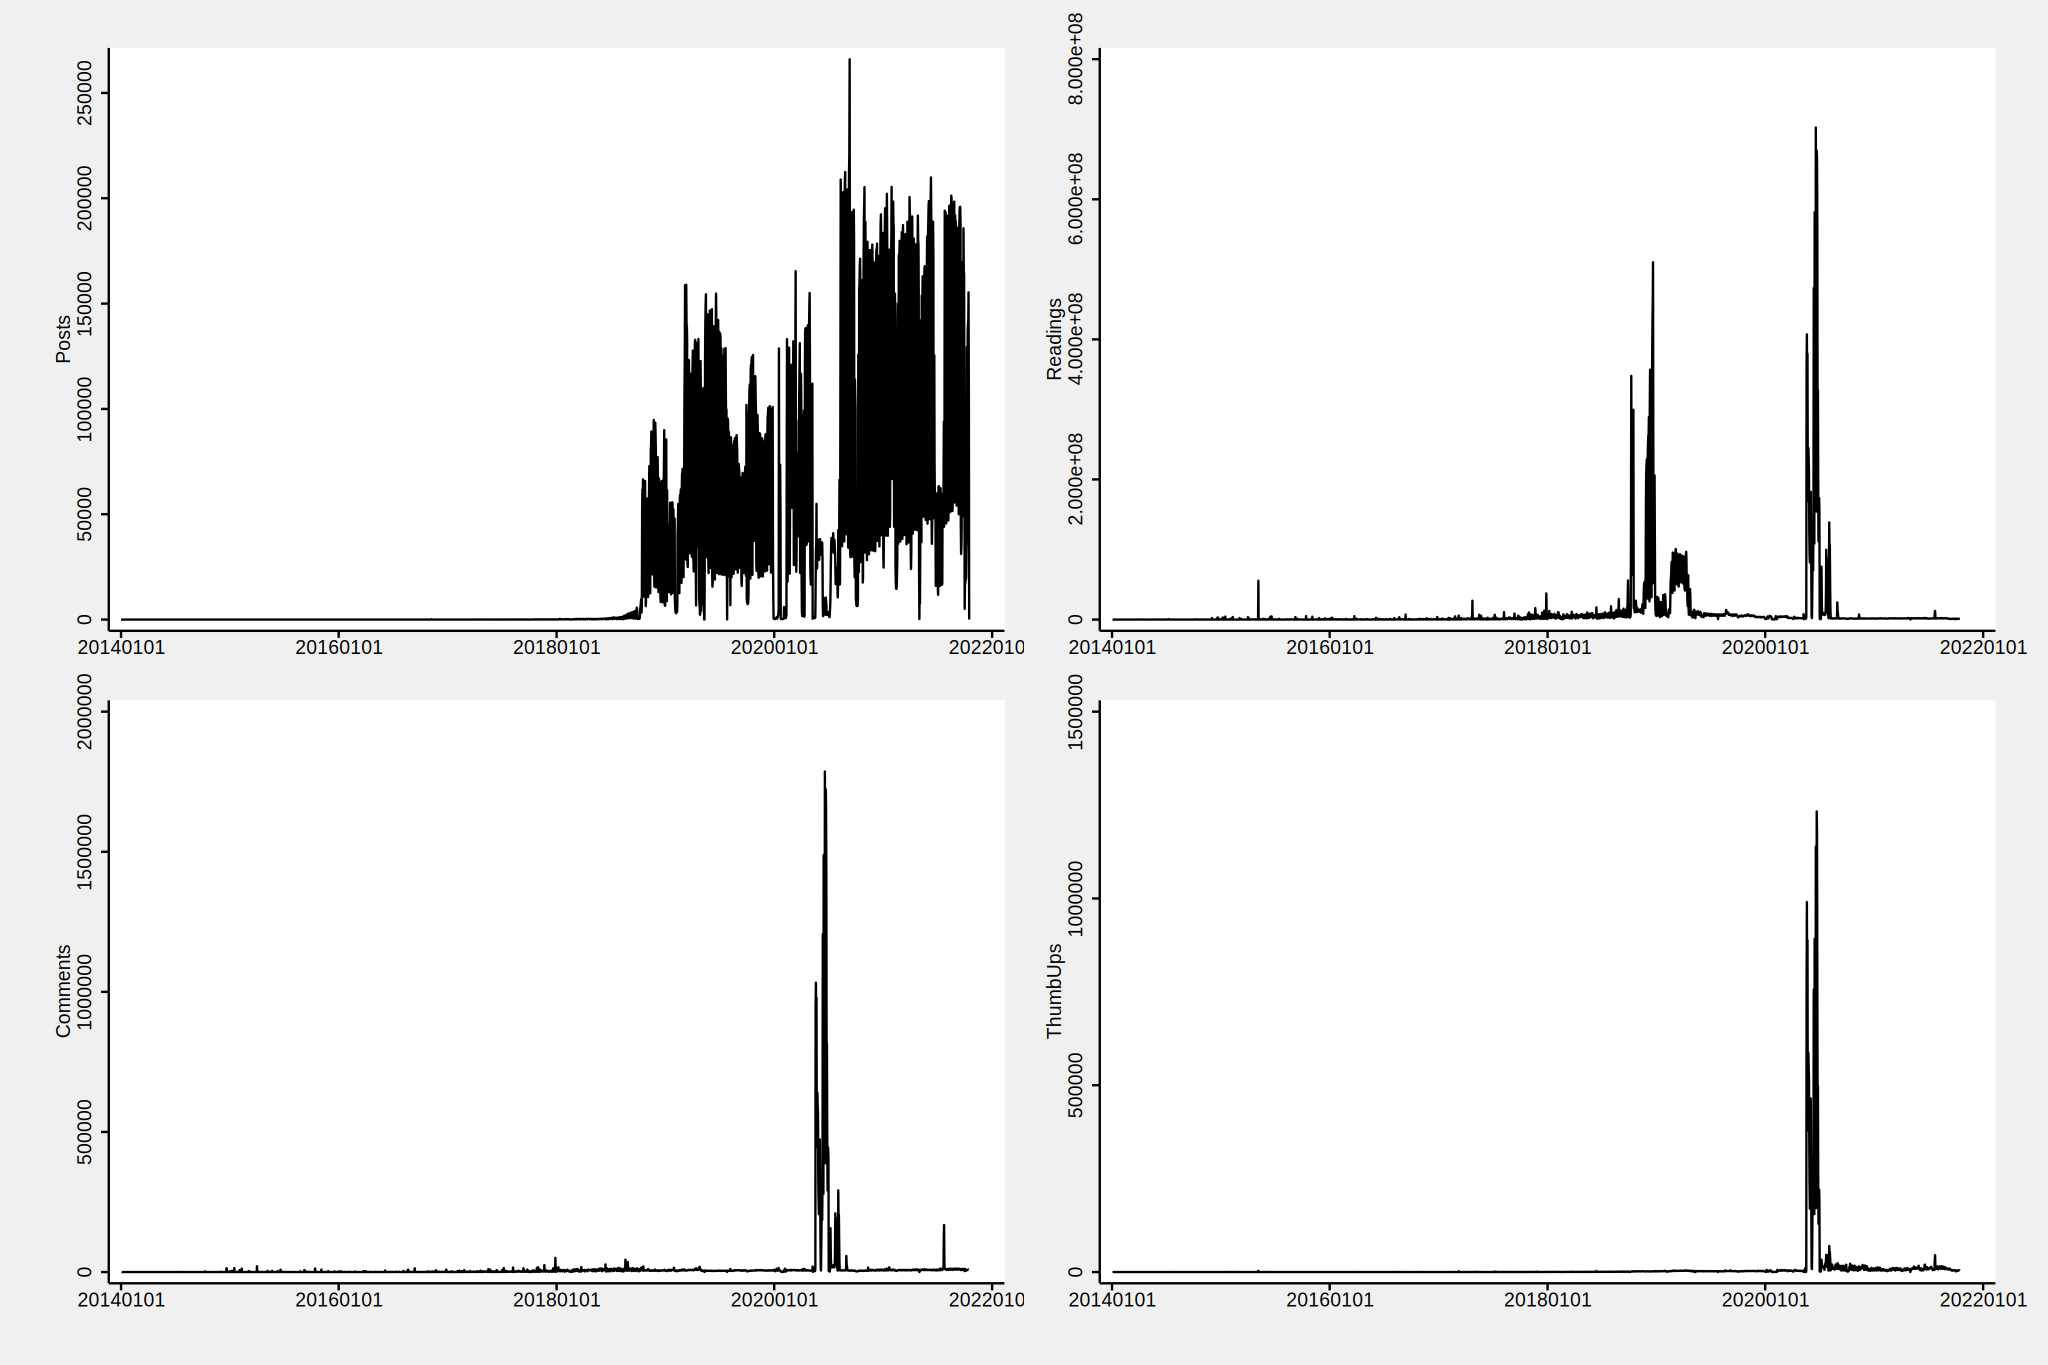

In [10]:
%%stata  -gw 12in -gh 8in
graph combine Posts Readings Comments ThumbUps , xcommon iscale(*0.5)  scheme(sj)